<a id="title_ID"></a>
# Taking a Tour of the TESS 2-minute Cadence Data
<br>
This notebook tutorial gives a brief tour of the contents of the TESS (Transiting Exoplanet Survey Satelite) 2-minute cadence data products. The tour will demonstrate how to extract the most useful data from these data files. This notebook assumes basic understanding of the FITS file format and basic python proficiency. The notebook uses examples to describe some of the features of the TESS file types.

### Table of Contents 
<div style="text-align: left"> <br> [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br> [Getting the Data](#data_ID) <br> [Contents of Target Pixel Files](#TPF_ID) <br> [Example Usage of TPF](#TPFUsage_ID) <br> [Contents of Light Curve Files](#LCF_ID) <br> [Additional Resources](#resources_ID) <br> [About this Notebook](#about_ID) </div>

***

<a id="intro_ID"></a>
## Introduction
TESS  only downloads select portions of the sky at a 2-minute cadence. The pixels collected around chosen targets are packaged in a file called the Target Pixel file. Light curve files contain the time series photometry that is derived from those pixels for each target. Each target pixel file packages these pixels as a time series of images in a binary FITS table. These files can then be used to measure the relative photometry of the observed star.  TESS also produces full frame images at a 30-minute cadence. We do not discuss those in this notebook.

For more information about the TESS mission and collected data, visit the [MAST's TESS homepage](http://archive.stsci.edu/tess/). To read more details about TESS Data Products, look in the [TESS Science Product Description Document](https://archive.stsci.edu/missions/tess/doc/EXP-TESS-ARC-ICD-TM-0014.pdf). Once users understand the TESS data, a convenient software package to work with that data is called [lightkurve](https://lightkurve.keplerscience.org/). However we do not use it below in order to clearly show how the data files are organized. 

[Top of Page](#title_ID)

***

<a id="imports_ID"></a>
## Imports
Let's start by importing some libraries to the environment: 
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.wcs WCS* for World Coordinate Systems
- *matplotlib.pyplot* for plotting data

Note *%matplotlib inline* allows us to see our plots in the notebook.

In [60]:
%matplotlib inline  
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

[Top of Page](#title_ID)

***

In [61]:
#Change ddir below to the relative location of the data files.
ddir="./tess-data-alerts/"
lcfile=ddir+"hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_lc.fits"
tpfile=ddir+"hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_tp.fits"

[Top of Page](#title_ID)

***

<a id="TPF_ID"></a>
## Contents of Target Pixel File

Now that we have the file, we can now explore its contents. 
The target pixel file contains 4 extensions, a primary header, a PIXELS extension, an APERTURE extension and a Target Cosmic Ray extension.

- **No. 0 (Primary): **
<br>This HDU contains meta-data related to the entire file.
- **No. 1 (Pixels): **
<br>This HDU contains a binary table that has 11 columns containing a time series of either scalar values or images. 
- **No. 2 (Aperture): **
<br>This HDU contains an image that gives information about each pixel and how it was used by ther TESS pipeline in the data processing. 
- **No. 3 (Target Cosmic Ray): ** 
<br> This HDU is new in the TESS target pixel files and describes the cosmic rays that were identified and subtracted from the target pixels. These cosmic ray corrections are only available if the TESS Pipeline cosmic ray correction algorithm was enabled during processing.

In [3]:
fits.info(tpfile)
tphdu=fits.open(tpfile)

Filename: ./tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   20076R x 11C   [D, E, J, 121J, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


<a id="TPF_ID"></a>
** Contents of the PIXELS extension. **
The pixels extension contains raw and calibrated pixels collected by the spacecraft at a 2-minute cadence. Here is a sumary of the columns available in that extension.

- TIME: Time of mid-cadence stored in BJD-2457000.0.
- CADENCENO: Cadence number
- RAW_CNTS: The raw counts per pixel before any processing.
- FLUX: The calibrated, background subtracted pixels for each cadence.
- FLUX_BKG: The background estimated for these pixels. 
- QUALITY: Quality flags.
- POS_CORR1 & POS_CORR2: The (column,row) local motion of the star calculated from the motion polynomials. Motion polynomials are calculated from the PSF centroids of select stars on each CCD. 

In [62]:
tphdu[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '121J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(11,11)'
    name = 'FLUX'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

** Show First Calibrated Image. ** Note that the RAW_CNTS, FLUX and FLUX_BKG columns contain images. We will use the World Coordinate System information in the APERTURE extension header to overlay the RA and Dec on the image.

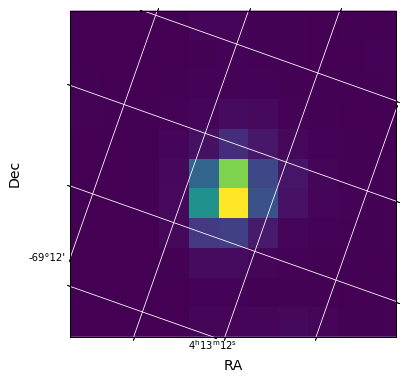

In [53]:
#Plot the first image of the FLUX Column with WCS overlay.
tpf_data=tphdu[1].data
first_image=tpf_data['FLUX'][1]

#The aperture extension header contains the same WCS as that in the Pixels extension.
wcs=WCS(tphdu[2].header)

#Plot
fig = plt.figure(figsize=(6,6))
fig.add_subplot(111, projection=wcs)
plt.imshow(first_image, origin='lower', cmap=plt.cm.viridis)
plt.xlabel('RA',fontsize=14)
plt.ylabel('Dec',fontsize=14)
plt.grid(axis='both',color='white', ls='solid')

[Top of Page](#title_ID)

<a id="TPFUsage_ID"></a>
### Example Usage of Target Pixel File
The most common usage of this file is to create a light curve from the pixels stored in the PIXELS HDU.  We will show how to make the exact light curve found in the light curve SAP_FLUX column and then highlight some of the other information in this file.

### Example 1. Create the optimal aperture light curve from the pixels. 
** Step 1. Read in the Aperture information from the third extension. **
Each pixel in the aperture extension image is an integer that represents a set of binary flags.  The entire set of flags and what they mean can be found in the TESS Archive Manual.  Of interest to us in this exersize is which pixels belong to the "optimal aperture" used to create this target's light curve. This is the second bit of this set of binary flags. To determine which pixels are in the optimal aperture we need to do a bitwise AND between the pixel value and the value 2. (Similarly, if you wanted to determine which pixels were used to calculate the flux-weighted centroid, you would use the 4th bit which has a value of  2^(4-1)=8.)

In [6]:
ap_image=(tphdu[2].data)
ap_want=np.bitwise_and(ap_image, 2) / float(2)
print(ap_want)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


** Step 2. Create time series photometry using these pixels ** For each cadence we will sum the values in the FLUX column associated with those pixels that show a '1' above.

In [7]:
#define a simple aperture function to sum-up specified pixels for one cadence
def aperture_phot(image,aperture):
    
    flux=np.sum(image[aperture==1])

    return flux

In [8]:
#Use the map lambda functions to apply that function to all cadences
opap_flux=np.array(list(map(lambda x: aperture_phot(x,ap_want), tpf_data['FLUX'])))
print(opap_flux[1:10])

[8025.5674 8049.3604 8063.4863 8035.2324 8050.272  8041.7305 8039.628
 8044.776  8037.0723]


** Step 3. Extract the Array of Times from the FLUX Extension. ** The resulting plot will be better understood if we extract the Barycentric Julian Dates from the file. Times in TESS are all offset by a value that is stored in the header under BJDREFI + BJDREFF.


In [9]:
time_bjd=tpf_data["TIME"]
tpf_head=tphdu[1].header
bjd_ref=tpf_head['BJDREFI'] + tpf_head['BJDREFF']
time=time_bjd+bjd_ref
print("TESS JD Offset is: %f" % bjd_ref)

TESS JD Offset is: 2457000.000000


** Step 4. Plot the resulting light curve. **  Plot the time vs optimal aperture flux.

Text(0.5,1,'TESS Lightcurve from Target Pixel File.')

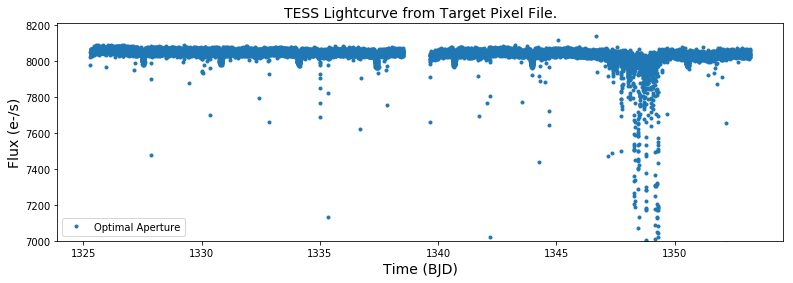

In [10]:
plt.figure(figsize=(13,4))
plt.plot(time_bjd,opap_flux,'.',label='Optimal Aperture',ms=6)
plt.legend(loc="lower left")
plt.xlabel('Time (BJD)',fontsize=14)
plt.ylabel('Flux (e-/s)',fontsize=14)
plt.ylim(7000,8210)
plt.title("TESS Lightcurve Derived from Calibrated Pixels.",fontsize=14)

### Example 2. Create a light curve of the background flux that was subtracted.
This is very similar to the steps above, except that we want to apply the aperture to the background flux estimated for this part of the sky. This information is stored as images in the FLUX_BKG extension.  Note that this background has already been subtracted from the flux values provided in the FLUX column.
<br><br>
** Step 1. Determine the flux from the background in the optimal aperture. **
This is done using that same aperture_phot function we wrote above. And we are using the same optimal aperture we defined above. 

In [11]:
back_im=tpf_data['FLUX_BKG']
back_opap_flux=list(map(lambda x: aperture_phot(x,ap_want), back_im))

** Step 2. Plot this background flux against the time. **

Text(0.5,1,'TESS Background Lightcurve from Target Pixel File.')

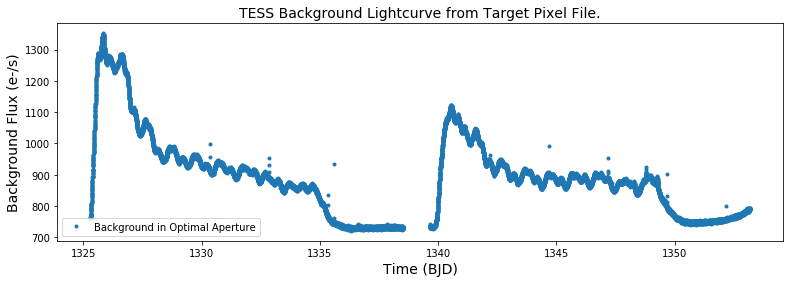

In [12]:
plt.figure(figsize=(13,4))
plt.plot(time_bjd,back_opap_flux,'.',label='Background in Optimal Aperture',ms=6)
plt.legend(loc="lower left")
plt.xlabel('Time (BJD)',fontsize=14)
plt.ylabel('Background Flux (e-/s)',fontsize=14)
plt.title("TESS Background Lightcurve from Target Pixel File.",fontsize=14)

Recall that TESS orbits the earth approximately every 2 weeks. We can see that the background flux changes signficantly depending on where the spacecraft is in its orbit.

[Top of Page](#title_ID)

***

<a id="LCF_ID"></a>
## Contents of the Light Curve File
The light curve file uses the information from the pixels to determine time series photometry. It also contains a host of information regarding the quality of each cadence, the observed motion of the star and how the light curve was extracted.  The extensions available in these data files are as follows. 

- **No. 0 (Primary): **
<br>This HDU contains meta-data related to the entire file.
- **No. 1 (Lightcurve): **
<br>This HDU contains a binary table that has 11 columns containing a time series of either scalar values or images. 
- **No. 2 (Aperture): **
<br>This HDU contains an image that gives information about each pixel and how it was used by ther TESS pipeline in the data processing. This is the same as the target pixel file. 

Recall that we defined lcfile above to point to the file hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_lc.fits.

In [13]:
lchdu=fits.open(lcfile)
fits.info(lcfile)

Filename: ./tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   20076R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


** Lighturve Extension. ** The lightcurve extension contains most of the data in this type of file. Let's list the columns available in this extension. Unlike the target pixel file, all these data are simply arrays instead of images. Here is a quick run down of the most important inormation in this file. 

- TIME: stored in BJD-2457000
- CADENCENO: Cadence number
- SAP_FLUX: Simple aperture photometry flux. (This is what we calculated above.)
- SAP_BKG: Background flux that has already been removed from SAP_FLUX. 
- PDCSAP_FLUX: Systematics corrected photometry using cotrending basis vectors.
- QUALITY: Quality flags
- PSF_CENTR1 & PSF_CENTR2: The (column,row) position of the star measured using PSF photometry.
- MOM_CENTR1 & MOM_CENTR2: The (column,row) position of the star measured using flux weighted centroids.
- POS_CORR1 & POS_CORR2: The (column,row) local motion of the star calculated from the motion polynomials. Motion polynomials are calculated from the PSF centroids of select stars on each CCD. 

Note, while there is a WCS in the header of these files, it refers to one cadence near the middle of sector. The POS_CORR columns provide information about small changes to that WCS.

In [14]:
#Open and view columns in lightcurve extension
lcdata=lchdu[1].data
lchdu[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

***

### Example Usage of the Light Curve File.

### Example 3. Compare the SAP_FLUX and PDCSAP_FLUX light curves. 
We will also mark bad cadences using the quality flag column.

** Step 1. Plot both types of fluxes against time. **

(8500, 9510)

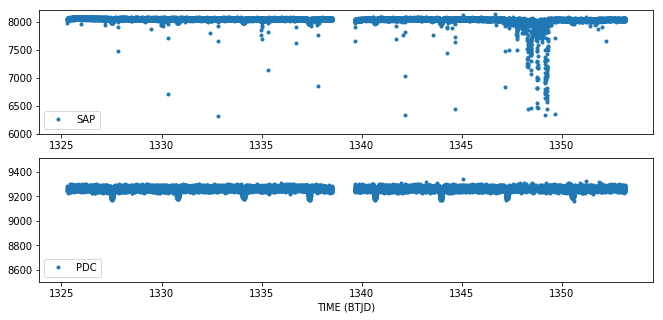

In [15]:
sapflux=lcdata['SAP_FLUX']
pdcflux=lcdata['PDCSAP_FLUX']
quality=lcdata['QUALITY']
time=lcdata['TIME']

fig=plt.figure(figsize=(11,5))
fig.add_subplot(211)
plt.plot(time,sapflux,'.',label='SAP')
plt.legend(loc='lower left')
#Zoom in to see anything.
plt.ylim(6000,8210)
fig.add_subplot(212)
plt.plot(time,pdcflux,'.',label='PDC')
plt.legend(loc='lower left')
plt.xlabel('TIME (BTJD)')
plt.ylim(8500,9510)

** A few things to notice here. ** The PDC light curve fits basis vectors to co-trend those anomalies that are common to all stars that are on the same CCD. In this way it removes many of the larger anomalies. PDC also gaps cadences which is why many of the highly scattered points are not present in the PDC light curve.

** Step 2. Clean-up both plots by removing cadences flagged as anomalous. ** The Quality column contains integers that act as binary flags identified in the TESS data. We are going to remove the data that has been flagged by one of the following flags:

- Bit 1. Attitude Tweak
- Bit 2. Safe Mode
- Bit 3. Coarse Point
- Bit 4. Earth Point
- Bit 5. Argabrightening Event (Sudden brightening across the CCD.)
- Bit 6. Reaction Wheel Desaturation
- Bit 8. Manual Exclude
- Bit 10. Impulsive outlier
- Bit 12. Straylight detected

The other flags are informational and do not necessarily indicate that the cadence should not be used. However, you may have scientifically valid reasons for removing those cadences as well, so it is worth learning about them. See the [archive manual](https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual) for a full listing of the flags. 

In [78]:
bad_bits=np.array([1,2,3,4,5,6,8,10,12])
value=0
for v in bad_bits:
    value=value+2**(v-1)
    
bad_data=np.bitwise_and(quality, value) >= 1 
print(bad_data[0:5])

[ True False False False False]


** Step 3. Create the same plot as before now removing the flagged data columns. ** Notice how well it cleans up the data and the plot now autoscales so we can see the transits of TESS Object of Interest TOI-114.01.

Text(0.5,0,'TIME (BTJD)')

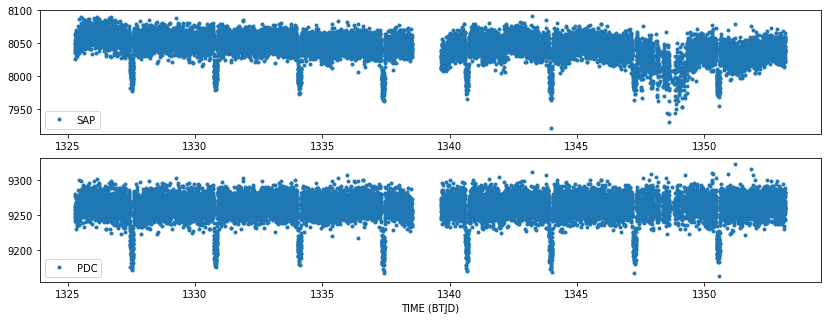

In [17]:
#Same plot as before with flagged data removed.
fig=plt.figure(figsize=(14,5))
fig.add_subplot(211)
plt.plot(time[~bad_data],sapflux[~bad_data],'.',label='SAP')
plt.legend(loc='lower left')
fig.add_subplot(212)
plt.plot(time[~bad_data],pdcflux[~bad_data],'.',label='PDC')
plt.legend(loc='lower left')
plt.xlabel('TIME (BTJD)')

***

### Example 4.  Plot the spacecraft motion.   
We will plot the measured (col,row) position of the star as measured from the flux weighted centroids. The spacecraft dumps the momentum gathered in its wheels every once and a while. We can mark when that happens by using the quality flags (bit 6, see above).

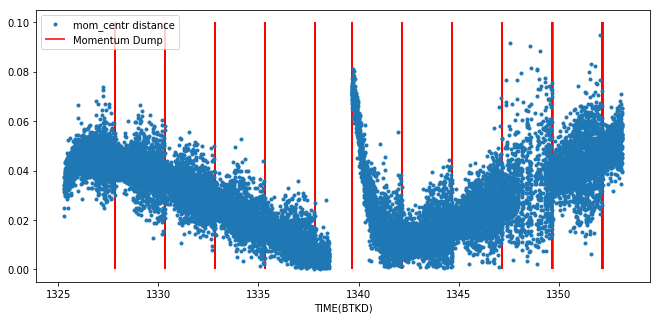

In [63]:
fluxcent_col=lcdata['MOM_CENTR1']
fluxcent_row=lcdata['MOM_CENTR2']
distance=((fluxcent_col-np.nanmean(fluxcent_col))**2 + (fluxcent_row-np.nanmean(fluxcent_row))**2)**(0.5)

mom_dump=np.bitwise_and(quality, 2**5) >= 1 

plt.figure(figsize=(11,5))
plt.plot(time[~bad_data],distance[~bad_data],'.',label="mom_centr distance")
plt.vlines(time[mom_dump],0,.1,colors='r',label="Momentum Dump")
plt.xlabel('TIME(BTKD)')
plt.legend(loc="upper left")

Notice that the momentum dumps are correlated with reduced scatter in the motion. Also notice that the time of large scatter in our photometry is correlated with the large scatter in the motion. 

[Top of Page](#title_ID)

***

### Example 5. Compare Light Curves
Now that we have a SAP_FLUX light curve and and the light curve we calculated with the target pixel files (opap_flux), we can show that indeed the data is the same by plotting the two light curves on top of each other. The lower subplot shows the difference. The small scatter in the residuals is caused by rounding error.

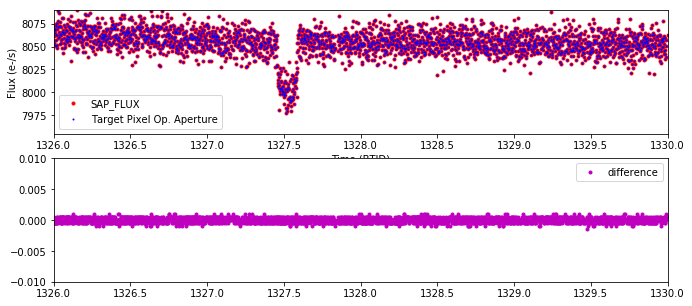

In [65]:
# sapflux is the photometry calculated by the pipeline.
# opap_flux is the photometry we calculated from the pixels.
fig=plt.figure(figsize=(11,5))
fig.add_subplot(211)
plt.plot(time[~bad_data],sapflux[~bad_data],'r.',label="SAP_FLUX")
plt.plot(time[~bad_data],opap_flux[~bad_data],'b.',ms=2,label="Target Pixel Op. Aperture")
plt.xlabel("Time (BTJD)")
plt.ylabel("Flux (e-/s)")
plt.legend(loc="lower left")
plt.xlim(1326,1330)
plt.ylim(7955,8090)
fig.add_subplot(212)
plt.plot(time[~bad_data],opap_flux[~bad_data]-sapflux[~bad_data],'m.',label="difference")
plt.ylim(-.01,.01)
plt.xlim(1326,1330)
plt.legend()

[Top of Page](#title_ID)

***

### Exercise for the Reader
a) The "rain plot" was used in the early days of Kepler to see if there are potential shifts in the flux-weighted centroids of the star during the transits. This can be an indication that there is a background eclipsing binary causing the transit-like shape, though the evidence is not definitive.  Can you plot the motion of the star on the detector (separately in row and column) as a function of flux? Bonus points if you normalize the flux first.

b) Determine which pixels were used by the pipeline to calculate the flux-weighted centroids?


In [67]:
#Place your answer here
#(a)



In [69]:
#(b)



***

Text(0,0.5,'change in flux')

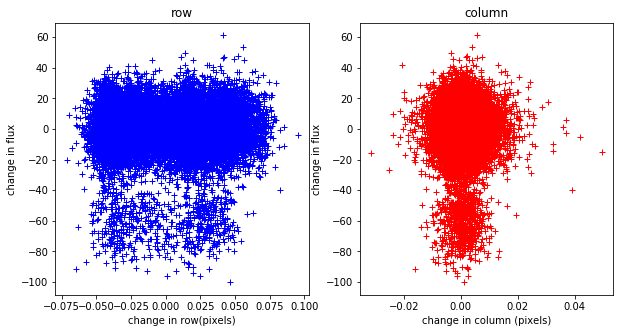

In [77]:
#Solution to (a)
#Here we choose do a simple normalization by subtracting off the median.
normflux=pdcflux[~bad_data]-np.nanmedian(pdcflux[~bad_data])
fwNorm_row=fluxcent_row[~bad_data]-np.nanmedian(fluxcent_row[~bad_data])
fwNorm_col=fluxcent_col[~bad_data]-np.nanmedian(fluxcent_col[~bad_data])

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(fwNorm_row,normflux,'b+')
plt.title("row")
plt.xlabel("change in row(pixels)")
plt.ylabel("change in flux")
plt.subplot(122)
plt.plot(fwNorm_col,normflux,'r+')
plt.title("column")
plt.xlabel("change in column (pixels)")
plt.ylabel("change in flux")

** Interpretation. ** No motion is correlated with the flux according to the flux weighted centroids. However there is apparently some significant motion along the CCD rows through-out the observations. 

[Top of Page](#title_ID)

[[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False  True  True False False False False False]
 [False False False False  True  True  True False False False False]
 [False False False False  True  True  True False False False False]
 [False False False False False  True False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]


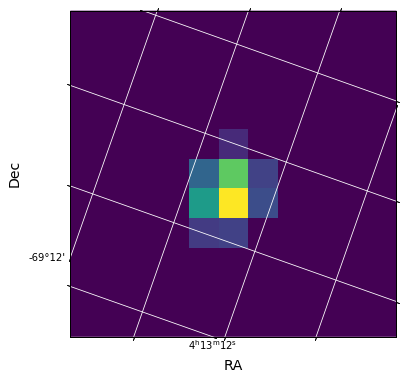

In [58]:
#Solution to (b)
#Let's display those pixels used in the flux-weighted centroid, we need to consider bit 4 of the aperture extension.
ap_image=(tphdu[2].data)
ap_want=np.bitwise_and(ap_image, 8)  >1
print(ap_want)
#Notice that it is the same as the optimal aperture. This may not always be the case.

#If we set all other pixels to 0 we can plot just those pixels in this aperture from the third cadence.
one_image=tpf_data['FLUX'][2]
fw_first=one_image
fw_first[~ap_want]=0
fig = plt.figure(figsize=(6,6))
fig.add_subplot(111, projection=wcs)
plt.imshow(fw_first, origin='lower', cmap=plt.cm.viridis)
plt.xlabel('RA',fontsize=14)
plt.ylabel('Dec',fontsize=14)
plt.grid(axis='both',color='white', ls='solid')

***

In [59]:
#Close the FITS files for good practice.
lchdu.close()
tphdu.close()

<a id="resources_ID"></a>
## Aditional Resources
For more information about the MAST archive and details about mission data:
<br>
<br>[MAST API](https://mast.stsci.edu/api/v0/index.html)
<br>[TESS Archive Page (MAST)](https://archive.stsci.edu/tess)
<br>[TESS Archive Manual](https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual)
<br>[Exo.MAST website](https://exo.mast.stsci.edu/exo/ExoMast/html/exomast.html)

***

<a id="about_ID"></a>
## About this Notebook
**Author:** Susan E. Mullally, STScI Archive Scientist
<br>**Updated On:** 2018-10-05

***

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 